## Transfer Learning

- ***Finetuning the convnet***:Instead of random initializaion, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. Rest of the training looks as usual.
- ***ConvNet as fixed feature extractor***: Here, we will freeze the weights for all the network except that of the fully connected layer. This last fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.

In [3]:
# uncomment the below line to download the data and extract it
#!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
#!unzip hymenoptera_data.zip

In [4]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np

import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

In [5]:
import warnings
warnings.filterwarnings("ignore")

### Loading the dataset

In [6]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225])
    ])
}

In [7]:
data_dir = 'hymenoptera_data'

In [8]:
# setting image folder path and data augmentation
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                         data_transforms[x])
                 for x in ['train', 'val']}

In [9]:
# laoding the datasets
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                    batch_size=4, shuffle=True, num_workers=4)
                      for x in ['train', 'val']}

In [10]:
# saving the dataset sizes in a dict
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

In [11]:
print(image_datasets)

{'train': Dataset ImageFolder
    Number of datapoints: 244
    Root Location: hymenoptera_data\train
    Transforms (if any): Compose(
                             RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                             RandomHorizontalFlip(p=0.5)
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None, 'val': Dataset ImageFolder
    Number of datapoints: 153
    Root Location: hymenoptera_data\val
    Transforms (if any): Compose(
                             Resize(size=256, interpolation=PIL.Image.BILINEAR)
                             CenterCrop(size=(224, 224))
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None}


In [12]:
# classes
class_names = image_datasets['train'].classes

In [13]:
# setting the device to use for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Visualizing few Images

In [14]:
def imshow(im, title=None):
    """Imshow for Image Tensors."""
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    im = im.numpy().transpose((1, 2, 0))
    im = std * im + mean
    im = np.clip(im, 0, 1)
    
    # plotting the image
    plt.imshow(im)
    
    if title is not None:
        plt.title(title)
    
    plt.pause(0.001) # pausing to update the plots

In [15]:
# batch of training data
inputs, classes = next(iter(dataloaders['train']))

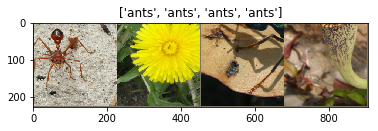

In [16]:
# making a grid from the batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

### Training the model

- Scheduling the learning rate
- Saving the best model

In [17]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-'*10)
        
        # each epoch has a train and val phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train() # set model to training mode
            else:
                model.eval() # set model to evaluate mode
                
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zeroing the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in 'train' mode
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase =='train':
                        loss.backward()
                        optimizer.step()
                
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds==labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Visualizing the model predictions

In [18]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():  # not tracking gradients
        
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            
            # converting to CUDA tensors
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # predicting the inputs
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return model.train(mode=was_training)

### Finetuning the convnet

In [19]:
# loading a pretrained model and reset final fully connected layer
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

In [20]:
model_ft = model_ft.to(device)

In [21]:
criterion = nn.CrossEntropyLoss() # Loss criteria

In [22]:
# optimizing all parameters
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

In [23]:
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### Train and evaluate

In [24]:
model_ft = train_model(model_ft, criterion, optimizer_ft,
                       exp_lr_scheduler, num_epochs=25)

Epoch 1/25
----------
train Loss: 1.7897 Acc: 0.6434
val Loss: 1.7524 Acc: 0.5425

Epoch 2/25
----------
train Loss: 0.9119 Acc: 0.7213
val Loss: 0.9638 Acc: 0.7124

Epoch 3/25
----------
train Loss: 0.6289 Acc: 0.7787
val Loss: 0.4227 Acc: 0.8497

Epoch 4/25
----------
train Loss: 0.6478 Acc: 0.7828
val Loss: 0.8263 Acc: 0.7059

Epoch 5/25
----------
train Loss: 0.6301 Acc: 0.7705
val Loss: 0.5651 Acc: 0.8562

Epoch 6/25
----------
train Loss: 0.5322 Acc: 0.8033
val Loss: 0.5676 Acc: 0.7908

Epoch 7/25
----------
train Loss: 0.4762 Acc: 0.8074
val Loss: 0.4875 Acc: 0.8562

Epoch 8/25
----------
train Loss: 0.3861 Acc: 0.8443
val Loss: 0.3236 Acc: 0.8693

Epoch 9/25
----------
train Loss: 0.3765 Acc: 0.8484
val Loss: 0.2942 Acc: 0.8824

Epoch 10/25
----------
train Loss: 0.3348 Acc: 0.8648
val Loss: 0.2894 Acc: 0.8824

Epoch 11/25
----------
train Loss: 0.2823 Acc: 0.8811
val Loss: 0.2858 Acc: 0.9020

Epoch 12/25
----------
train Loss: 0.2595 Acc: 0.8934
val Loss: 0.2477 Acc: 0.9020

E

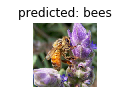

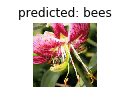

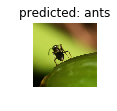

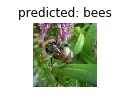

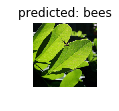

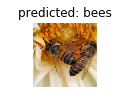

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [25]:
visualize_model(model_ft)